In [18]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt


fname = '../data/100_unrelated.csv'
subjectids = np.loadtxt(fname, dtype=np.int)
nSubj = len(subjectids)
tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
         'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
         'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
         'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
         'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
         'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']

M = {}
for task in tasks:
    masterFC_dir = '../data/results_SIFT2'
    restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
    task_matrices = []
    for subject in subjectids:
        filename = masterFC_dir + '/' + str(subject) + '/' + restingstatename
        mat = sio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        A_orig = mat['FC']
        np.fill_diagonal(A_orig, 0)
#         A_orig = A_orig[np.triu_indices(A_orig.shape[0])] #only use upper triu values since symmetric
        task_matrices.append(A_orig)
    # This is the 100 by 374 by 374 matrices of 100 unrelated subjects
    task_matrices = np.array(task_matrices).reshape(len(subjectids),-1)
    M[task] = task_matrices


In [19]:
task_list = ["Rest", "Emotion", "Gambling", "Language", "Motor", "Relational", "Social", "WM"]

In [68]:
all_FC = np.hstack((M['rfMRI_REST1_LR'],M['rfMRI_REST1_RL'],M['tfMRI_EMOTION_LR'],M['tfMRI_EMOTION_RL'],
                  M['tfMRI_GAMBLING_LR'], M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_LR'], M['tfMRI_LANGUAGE_RL'],
                  M['tfMRI_MOTOR_LR'], M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_LR'], M['tfMRI_RELATIONAL_RL'],
                  M['tfMRI_SOCIAL_LR'], M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_LR'], M['tfMRI_WM_RL'] )).reshape(-1,M['tfMRI_WM_LR'].shape[1])

In [69]:
all_FC.shape

(1520, 70125)

## Deep Learning

In [63]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
from sklearn.preprocessing import StandardScaler

# GPU is available? If so, we use it.
use_cuda = torch.cuda.is_available() 
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print("GPU detected. Will use GPU for training!")
    torch.backends.cudnn.benchmark = True
else:
    print("No GPU detected. Will use CPU for training.")

No GPU detected. Will use CPU for training.


In [22]:
labels = torch.tensor(np.repeat(np.arange(0,8),nSubj*2), dtype=torch.long)
indices = np.random.permutation(labels.shape[0])
train_idx = indices[:int(0.6*labels.shape[0])]
val_idx = indices[int(0.6*labels.shape[0]):int(0.8*labels.shape[0])]
test_idx = indices[int(0.8*labels.shape[0]):]

In [23]:
std_scale = StandardScaler().fit(all_FC[train_idx,:])

In [24]:
all_FC[train_idx,:] = std_scale.transform(all_FC[train_idx,:])
all_FC[val_idx,:] = std_scale.transform(all_FC[val_idx,:])
all_FC[test_idx,:] = std_scale.transform(all_FC[test_idx,:])

In [25]:
all_FC.shape

(1520, 70125)

In [26]:
all_FC = torch.FloatTensor(all_FC)

In [27]:
train_data = []
for i in train_idx:
    train_data.append([all_FC[i], labels[i]])
    
val_data = []
for i in val_idx:
    val_data.append([all_FC[i], labels[i]])

test_data = []
for i in test_idx:
    test_data.append([all_FC[i], labels[i]])

In [33]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=100)

## NN Architecture

In [34]:
input_size = all_FC.shape[1] # number of columns
hidden_sizes = [2048, 128]
output_size = 8
max_epochs = 30
n_epochs_stop = 5

In [53]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.BatchNorm1d(hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))
if use_cuda:
    model = model.cuda()

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20*10*10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2,2)))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), (2,2)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model2 = Net()
print(model2)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


In [65]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


In [66]:

history = {}
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
min_val_loss = np.Inf
early_stop = False
# Loop over epochs


for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        

        opt.zero_grad()
        output = model(local_batch)
        loss = loss_fn(output, local_labels)
        loss.backward()
        opt.step()
        
        train_loss += loss.data.item() * local_batch.size(0)
        num_train_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_train_examples += local_batch.shape[0]
        
        train_acc = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_loader.dataset)
        
    # Validation
    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in val_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            loss = loss_fn(output, local_labels)
            
            val_loss += loss.data.item() * local_batch.size(0)
            num_val_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
            num_val_examples += local_batch.shape[0]
            
        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_loader.dataset)
        
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
  # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            early_stop = print('Early stopping!')
            break

        
    print(f'Epoch {epoch+1}/{max_epochs}, train loss: {train_loss:5.4f}, train acc: {train_acc:5.3f}, val loss: {val_loss:5.3f}, val acc: {val_acc:5.3f}')
    
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if early_stop:
        print("Stopped")
        break

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 10 1, but got 2-dimensional input of size [100, 70125] instead

In [38]:
local_batch.device

device(type='cpu')

In [39]:
model.eval()
num_correct  = 0
num_examples = 0
with torch.set_grad_enabled(False):
    for local_batch, local_labels in test_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model(local_batch)
        num_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_examples += local_batch.shape[0]
            
    test_acc  = num_correct / num_examples

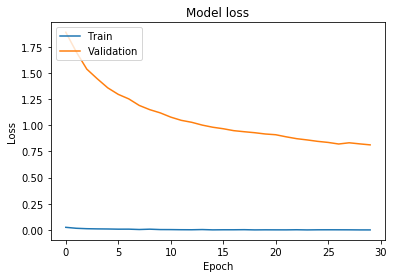

In [40]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

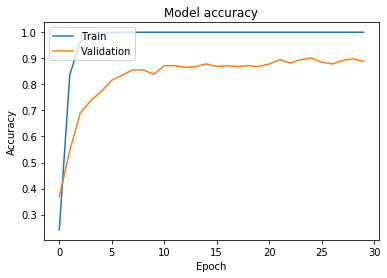

In [41]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
test_acc

0.8848684210526315